In [226]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import copy

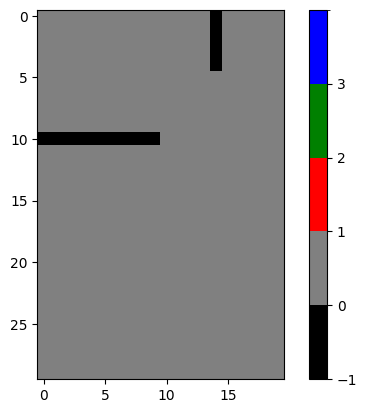

In [227]:
global_mat = np.zeros((30, 20), dtype=int)
global_mat[10, 0:10] = -1
global_mat[0:5, 14] = -1
NUM_COLOR = 3
COL_ORIGIN = {
    1: (12, 19),
    2: (13, 19),
    3: (14, 19)
}
CMAP = {-1: 'black', 0: 'grey', 1: 'red', 2: 'green', 3: 'blue'}

# 可视化写为函数，传入矩阵


def plot_matrix(matrix, title=None):
    cmap_list = [CMAP[key] for key in sorted(CMAP.keys())]
    custom_cmap = mcolors.ListedColormap(cmap_list)
    bounds = list(CMAP.keys()) + [max(CMAP.keys()) + 1]
    norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)
    if title is not None:
        plt.title(title)
    plt.imshow(matrix, cmap=custom_cmap, norm=norm)
    plt.colorbar(ticks=sorted(CMAP.keys()))
    plt.show()


plot_matrix(global_mat)

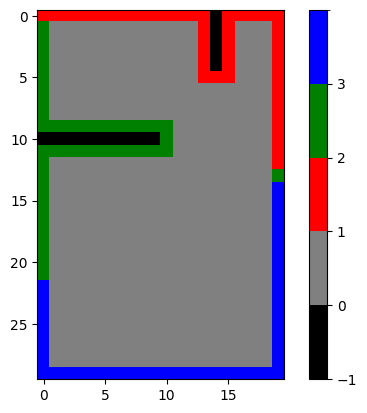

In [228]:
import numpy as np


def find_edge_ccw(mat, col, origin=None):
    # 定义方向向量（上、右、下、左）
    directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
    edge = []
    if origin is None:
        for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                if mat[i, j] == col:
                    origin = (i, j)
                    break
            if origin is not None:
                break
    current = origin
    edge.append(current)
    dir = 0

    while current != origin or len(edge) == 1:
        # 能右转就右转

        def nxt(x, dir):
            return (x[0] + directions[dir][0], x[1] + directions[dir][1])

        def ok(x):
            return 0 <= x[0] < mat.shape[0] and 0 <= x[1] < mat.shape[1] and mat[x] == col

        for i in range(5, 1, -1):
            if ok(nxt(current, (dir + i) % 4)):
                dir = (dir + i) % 4
                current = nxt(current, dir)
                edge.append(current)
                break

    return edge


# 示例矩阵和起点

mat1 = global_mat.copy()
# 计算边界
edge = find_edge_ccw(mat1, 0, COL_ORIGIN[1])
edge = edge[1:len(edge) - NUM_COLOR]

for key, value in COL_ORIGIN.items():
    mat1[value] = key
# 将 edge 前 1 / 3 存入 col_edge 1 并染色为红色
col_edge = {
    1: edge[:len(edge) // NUM_COLOR],
    2: edge[len(edge) // NUM_COLOR:2 * len(edge) // NUM_COLOR],
    3: edge[2 * len(edge) // NUM_COLOR:]
}

for key, value in col_edge.items():
    for point in value:
        mat1[point] = key

plot_matrix(mat1)

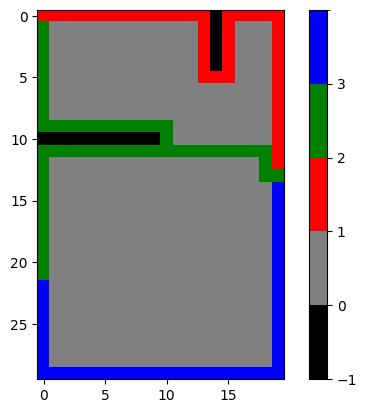

In [229]:
import heapq
mat2 = copy.deepcopy(mat1)


# 启发式搜索算法（A*）

def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])


def a_star_search(mat, start, end):
    directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, end)}

    while open_set:
        current = heapq.heappop(open_set)[1]

        if current == end:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            path.reverse()
            return path

        for direction in directions:
            neighbor = (current[0] + direction[0], current[1] + direction[1])
            if 0 <= neighbor[0] < mat.shape[0] and 0 <= neighbor[1] < mat.shape[1] and (mat[neighbor] == mat[start] or mat[neighbor] == 0):
                tentative_g_score = g_score[current] + 1
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + \
                        heuristic(neighbor, end)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return []


# 示例矩阵和起点
# 对 i in range(2, num)，从 origin[i] 启发式搜索到 col_edge[i] 的中间那个点，一路上的路径染成对应颜色
for x in range(2, NUM_COLOR):
    start = COL_ORIGIN[x]
    end = col_edge[x][len(col_edge[x]) // 2]
    path = a_star_search(mat1, start, end)
    for point in path:
        mat2[point] = x

plot_matrix(mat2)

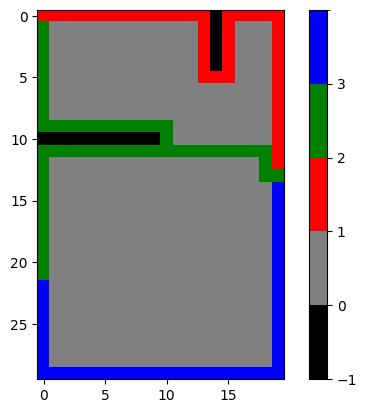

745.5


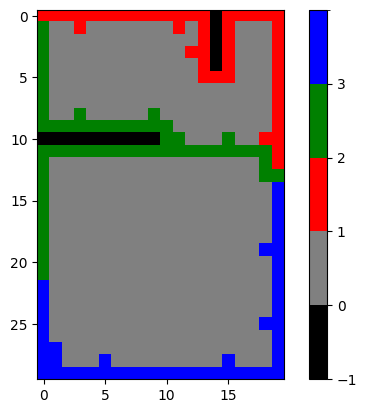

In [232]:
# YOUR CODE HERE
import random
import numpy as np
import copy

# 定义染色体表示方法


class Chromosome:
    def __init__(self, matrix):
        self.matrix = matrix

    def loss(self) -> float:
        loss = 0.0

        connected_components = self.count_connected_components()
        num_components = len(connected_components)
        if num_components > NUM_COLOR:
            return float('+inf')  # 不连通的染色体适应度为负无穷
        # 数一数不是黑色的网格个数
        num_non_black = np.sum(self.matrix != -1)
        num_each_color: float = num_non_black / NUM_COLOR
        loss += np.sum([np.abs(len(component) - num_each_color) **
                        1 for component in connected_components])
        # [折线次数]
        turn_cnt = 0
        for col in range(1, NUM_COLOR + 1):
            edge = find_edge_ccw(self.matrix, col, COL_ORIGIN[col])
            for i in range(len(edge)):
                pos = np.array(edge[i])
                pre_pos = np.array(edge[i - 1])
                pre_pre_pos = np.array(edge[i - 2])
                turn_cnt += np.any((pos - pre_pos) != (pre_pos - pre_pre_pos))
        loss += turn_cnt * 2
        # print(f'turn_cnt: {turn_cnt}')
        # [grey]
        grey_cnt = np.sum(self.matrix == 0)
        loss += grey_cnt * 0.5
        # gray_count = np.sum(self.matrix == 0)
        # color_distribution = [np.sum(self.matrix == color)
        #                       for color in range(1, NUM_COLOR + 1)]
        # color_variance = np.var(color_distribution)
        # return -gray_count - color_variance
        return loss

    def count_connected_components(self):
        # 计算连通分量
        visited = np.zeros_like(self.matrix, dtype=bool)
        components = []

        def dfs(x, y, color):
            stack = [(x, y)]
            component = []
            while stack:
                cx, cy = stack.pop()
                if not (0 <= cx < self.matrix.shape[0] and 0 <= cy < self.matrix.shape[1]):
                    continue
                if visited[cx, cy] or self.matrix[cx, cy] != color:
                    continue
                visited[cx, cy] = True
                component.append((cx, cy))
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    stack.append((cx + dx, cy + dy))
            return component

        for i in range(self.matrix.shape[0]):
            for j in range(self.matrix.shape[1]):
                if not visited[i, j] and self.matrix[i, j] > 0:  # 不是黑色和灰色
                    component = dfs(i, j, self.matrix[i, j])
                    if component:
                        components.append(component)

        return components

    def crossover(self, other):
        # 交叉函数
        # new_matrix = self.matrix.copy()
        # for i in range(new_matrix.shape[0]):
        #     for j in range(new_matrix.shape[1]):
        #         if random.random() < 0.5 and self.matrix[i, j] != -1:
        #             new_matrix[i, j] = other.matrix[i, j]
        # return Chromosome(new_matrix)
        return Chromosome(self.matrix.copy())

    def mutate(self, round_rate):
        # 变异函数
        # for i in range(self.matrix.shape[0]):
        #     for j in range(self.matrix.shape[1]):
        #         if random.random() < 0.1 and self.matrix[i, j] != -1:
        #             self.matrix[i, j] = random.randint(1, NUM_COLOR)
        # 灰色有概率变为相邻彩色中的一种，相邻越多概率越大
        nxt_matrix = self.matrix.copy()
        for x in range(self.matrix.shape[0]):
            for y in range(self.matrix.shape[1]):
                if self.matrix[x, y] == 0:
                    nb_cnt = {}
                    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                        nx, ny = x + dx, y + dy
                        if 0 <= nx < self.matrix.shape[0] and 0 <= ny < self.matrix.shape[1] and self.matrix[nx, ny] >= 0:
                            nb_cnt[self.matrix[nx, ny]] = nb_cnt.get(
                                self.matrix[nx, ny], 0) + 1
                        # 按照 softmax 分布随机选择一个颜色
                    softmax = np.exp(
                        list(nb_cnt.values())) / np.sum(np.exp(list(nb_cnt.values())))
                    nxt_matrix[x, y] = np.random.choice(
                        list(nb_cnt.keys()), p=softmax)
        self.matrix = nxt_matrix
        nxt_matrix = self.matrix.copy()
        pre_colored_pos = [(i, j) for i in range(
            self.matrix.shape[0]) for j in range(self.matrix.shape[1]) if nxt_matrix[i, j] > 0 and (i, j) not in COL_ORIGIN.values()]
        # shuffle
        random.shuffle(pre_colored_pos)
        # 有概率变为相邻异色，相邻越多概率越大
        for x, y in pre_colored_pos:
            # 获取周围八个方向
            sudoku_col = []
            cross_col = []
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = x + dx, y + dy
                cross_col.append(
                    nxt_matrix[nx, ny] if 0 <= nx < nxt_matrix.shape[0] and 0 <= ny < nxt_matrix.shape[1] else -1)

            for dx, dy in [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]:
                nx, ny = x + dx, y + dy
                sudoku_col.append(
                    nxt_matrix[nx, ny] if 0 <= nx < nxt_matrix.shape[0] and 0 <= ny < nxt_matrix.shape[1] else -1)

            # [np.int64(2), np.int64(1), np.int64(2), np.int64(3), np.int64(3), np.int64(0), np.int64(2), np.int64(2)] 1
            left_cnt = np.sum(
                [sudoku_col[k] == nxt_matrix[x, y] and
                 sudoku_col[k] != sudoku_col[k - 1] for k in range(len(sudoku_col))])
            if left_cnt <= 1:
                colored_cnt = {}
                for col in sudoku_col:
                    if col > 0 and col in cross_col:
                        colored_cnt[col] = colored_cnt.get(
                            col, 0) + 1
                # 变色后必须与新颜色相邻
                softmax = np.exp(
                    list(colored_cnt.values())) / np.sum(np.exp(list(colored_cnt.values())))
                to_col = np.random.choice(
                    list(colored_cnt.keys()), p=softmax)
                if to_col != nxt_matrix[x, y]:
                    # plot_matrix(
                    #     nxt_matrix, title=f'mutate {x} {y} {CMAP[to_col]}')
                    # print(sudoku_col, left_cnt, nxt_matrix[x, y])
                    if random.random() < np.exp(-round_rate * 5):
                        nxt_matrix[x, y] = to_col
        self.matrix = nxt_matrix


test_mat = mat2.copy()
plot_matrix(test_mat)
chromosome = Chromosome(test_mat)
print(chromosome.loss())
chromosome.mutate(1)
plot_matrix(chromosome.matrix)

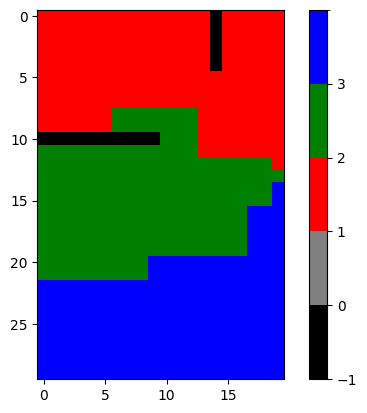

epoch 199 loss 88.0


In [ ]:
from IPython.display import clear_output


def initialize_population(size, col):
    population = []
    for _ in range(size):
        matrix = col.copy()
        population.append(Chromosome(matrix))
    return population


def genetic_algorithm(col, iterations, population_size):
    population = initialize_population(population_size, col)
    for epoch in range(iterations):
        # new_population = []
        # selected = select(population)
        # for i in range(len(selected) // 2):
        #     parent1 = selected[i]
        #     parent2 = selected[len(selected) - i - 1]
        #     child1 = parent1.crossover(parent2)
        #     child2 = parent2.crossover(parent1)
        #     child1.mutate()
        #     child2.mutate()
        #     new_population.append(child1)
        #     new_population.append(child2)
        new_population = []
        population.sort(key=lambda x: x.loss())
        population = population[:population_size]
        K_CHILD = 4
        for i in range(len(population)):
            num_children = max(
                1, int(np.exp((-i / len(population) + 0.5) * K_CHILD)))
            for _ in range(num_children):
                child = population[i].crossover(population[i])
                child.mutate(epoch / iterations)
                new_population.append(child)
        population = new_population
        if epoch % 5 == 0 or epoch == iterations - 1:
            clear_output(wait=True)
            # plt.clf()
            plot_matrix(min(population, key=lambda x: x.loss()).matrix)
            print(f'epoch {epoch} loss {population[0].loss()}')
    return min(population, key=lambda x: x.loss())


iterations = 200
population_size = 6
best_chromosome = genetic_algorithm(mat2, iterations, population_size)

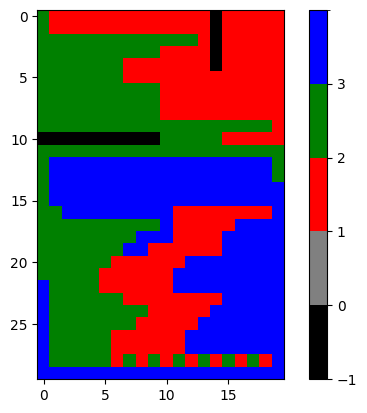

In [ ]:
col3 = copy.deepcopy(mat2)


def find_closest_uncolored_point(col, color, col_edge):
    min_distance = float('inf')
    closest_point = None
    for i in range(col.shape[0]):
        for j in range(col.shape[1]):
            if col[i, j] == 0:
                for edge_point in col_edge[color]:
                    distance = heuristic((i, j), edge_point)
                    if distance < min_distance:
                        min_distance = distance
                        closest_point = (i, j)
    return closest_point


# 循环若干次，每次对第 i % num + 1 种颜色，寻找最近的未染色点并染色
iterations = 500
for x in range(iterations):
    color = x % NUM_COLOR + 1
    closest_point = find_closest_uncolored_point(col3, color, col_edge)
    if closest_point:
        col3[closest_point] = color
        col_edge[color].append(closest_point)

plot_matrix(col3)